In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/petersim1/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1977 (delta 12), reused 20 (delta 7), pack-reused 1950
Receiving objects: 100% (1977/1977), 139.16 MiB | 38.50 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
gdrive_path = 'drive/MyDrive/DS-GA-3001/'
vae_modeldict_path = gdrive_path+'VAE_Trained.pth'

In [13]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

from project_extension.VAE import VAE

import torch
import torch.optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import DatasetFolder,ImageFolder

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [10]:
# load VAE model
# network architecture stored in repo
# network trained parameters stored locally (or on gdrive)
VAE_Model = VAE()
vae_state_dict = torch.load(vae_modeldict_path)
VAE_Model.load_state_dict(vae_state_dict)

<All keys matched successfully>

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [78]:
transform_size = transforms.Compose([
    transforms.ToTensor()
])

loader = ImageFolder('project_extension/vae_train_data',transform_size)

n = len(loader)  # total number of examples
n_test = int(0.25 * n)  # take ~10% for test

inds = np.arange(len(images.samples))
np.random.shuffle(inds)
train_inds,test_inds = inds[n_test:],inds[:n_test]


train_sampler = SubsetRandomSampler(train_inds)
test_sampler  = SubsetRandomSampler(test_inds)

train_loader = DataLoader(dataset=images,
                          batch_size=3,
                          sampler=train_sampler)

test_loader = DataLoader(dataset=images,
                          batch_size=1,
                          sampler=test_sampler)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


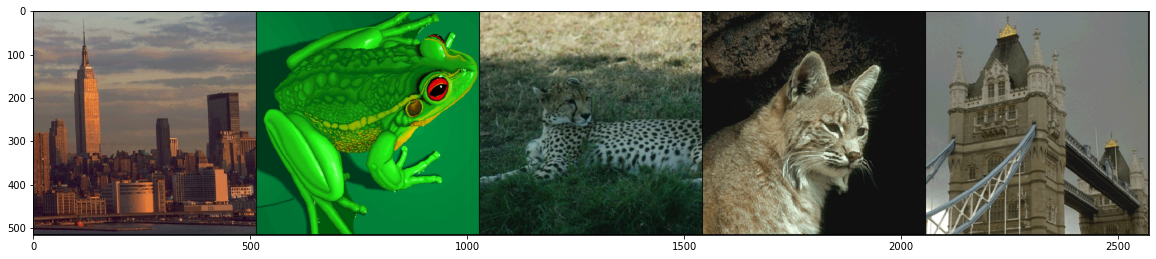

In [26]:
num_img_show = 5

for i in range(num_img_show) :
  im,_ = next(iter(train_loader))
  if i == 0 :
    img = torch.zeros((5,*im.size()[1:]))
  img[i] = im.clone().detach()

img = torch.tensor(img)
grid_img = torchvision.utils.make_grid(img, nrow=5)

plt.figure(figsize=(20,10))
plt.imshow(grid_img.permute(1, 2, 0))

In [77]:
def gen_random_input(mu,sigma,width,depth) :
  out = torch.zeros((depth,mu.size(-1),width))
  for i in range(width) :
    for j in range(depth) :
      out[j,:,i] = torch.normal(mu,sigma)
  return out

In [58]:
im,_ = next(iter(train_loader))
im_out,mu,logvar = VAE_Model(im)
sigma = logvar.mul(0.5).exp_()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
out = gen_input(mu,sigma,512,2)

In [76]:
out.size()

torch.Size([2, 512, 512])